# CartPole solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint quantum critic.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow.keras as keras
import tensorflow as tf

2024-01-30 12:21:41.772859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
import numpy as np
import cirq
import functools

state_bounds = tf.convert_to_tensor(np.array([2.4, 2.5, 0.21, 2.5], dtype='float32'))


def generate_model_critic_quantum_partite(
    n_agents,
    n_layers,
    beta = 1.0,
    squash_activation = 'linear', # linear, arctan/atan, tanh
    name=None,
    ):
    """eQMARL variant of hybrid quantum joint critic for CartPole.
    """
    # State boundaries for input normalization.
    state_bounds = tf.convert_to_tensor(np.array([2.4, 2.5, 0.21, 2.5], dtype='float32'))

    # Shape of observables is already known for CartPole..
    obs_shape = (4,1)

    # Qubit dimension is pre-determined for CartPole environment.
    # Using `4` to match observable dimension.
    d_qubits = 4

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(n_agents * d_qubits)

    # Single observable across all qubits.
    observables = [cirq.Z(q) for q in qubits]
    observables = [functools.reduce(lambda x, y: x*y, observables)]

    # Define quantum layer.
    qlayer = eqmarl.layers.HybridPartiteVariationalEncodingPQC(
        qubits=qubits, 
        n_parts=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        squash_activation=squash_activation,
        encoding_layer_cls=eqmarl.ops.ParameterizedRotationLayer_Rx,
        )
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = functools.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(n_agents, input_size), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Lambda(lambda x: x/state_bounds), # Normalizes input states.
                keras.layers.Reshape((n_agents, *obs_shape)), # Reshape to agent observations.
                ], name="input-preprocess"),
            qlayer,
            keras.Sequential([
                eqmarl.layers.RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                # keras.layers.Softmax(),
                ], name='observables-joint-value')
        ], name=name)
    return model

In [5]:
n_actions = 2
n_agents = 2

In [6]:
# Quantum shared actor.
model_actor = eqmarl.models.generate_model_CartPole_actor_quantum(
    n_layers=5,
    name=f"actor-quantum-shared",
    )
optimizer_actor = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]


model_actor.build((None, 4))
model_actor.summary()

Model: "actor-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 1)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 2)                92        
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 2)                2         
 ial)                                                            
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Quantum joint critic.
model_critic = generate_model_critic_quantum_partite(
    n_agents=n_agents,
    n_layers=5,
    name=f"critic-quantum-joint",
    )
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]


model_critic.build((None, n_agents, 4))
model_critic.summary()

Model: "critic-quantum-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 2, 4, 1)          0         
 l)                                                              
                                                                 
 HybridPartiteVariationalEnc  (None, 1)                184       
 odingPQC (HybridPartiteVari                                     
 ationalEncodingPQC)                                             
                                                                 
 observables-joint-value (Se  (None, 1)                1         
 quential)                                                       
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


## Training

In [8]:
gamma = 0.99
alpha = 0.001
env = gym.vector.make('CartPole-v1', num_envs=n_agents)

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    )

reward_history, metrics_history = algo.train(n_episodes=3000, max_steps_per_episode=500)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 2066:  69%|██████▉   | 2066/3000 [59:12<26:46,  1.72s/episode, episode_reward=[16. 16.]]    

Terminating early at episode 2066


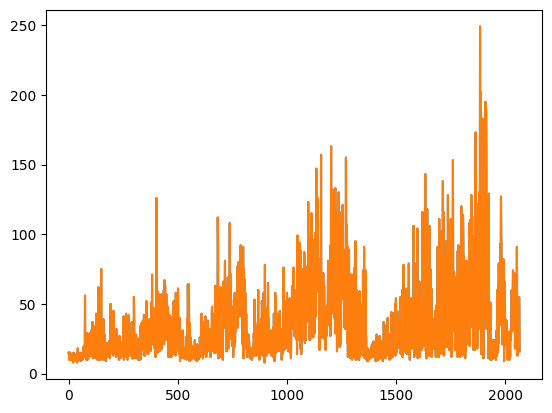

In [9]:
plt.plot(reward_history)